# IMPORT & SETUP

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [37]:
file_path = 'dataset/train.csv'
data = pd.read_csv(file_path)

features_used = ['Inherited from father', 'Maternal gene', 'Paternal gene', 'Genes in mother\'s side', 'Symptom 1',
                 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']
targets = ['Genetic Disorder', 'Disorder Subclass']

dataset = data.loc[:, features_used + targets].dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')
# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

dataset['Genetic Disorder'] = dataset.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']]
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)
dataset = dataset.drop(['Disorder Subclass'], axis=1)
# dataset = dataset.dropna(subset=['Disorder Subclass'], how='all')

# CATEGORIAL BINARY
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': 0.0, 'Yes': 1.0})
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': 0.0, 'Yes': 1.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})

# dataset = dataset.dropna(subset=['Symptom 4', 'Symptom 5'])
#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': 1,
    'Multifactorial genetic inheritance disorders': 0,
    'Single-gene inheritance diseases': 2,
}
dataset['Genetic Disorder'] = dataset['Genetic Disorder'].map(genetic_disorder_mapping)

# disorder_subclass_mapping = {
#     "Leber's hereditary optic neuropathy": 0,
#     'Cystic fibrosis': 1,
#     'Diabetes': 2,
#     'Leigh syndrome': 3,
#     'Tay-Sachs': 4,
#     'Mitochondrial myopathy': 5,
#     'Hemochromatosis': 6,
#     "Alzheimer's": 7,
#     'Cancer': 8,
# }
# 
# dataset['Disorder Subclass'] = dataset['Disorder Subclass'].map(disorder_subclass_mapping)
heat_data = dataset.copy().dropna()

,Inherited Father,Maternal gene,Paternal gene,Inherited Mother,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder
Inherited from father,0.00,0.01,0.10,0.02,0.01,0.00,0.00,0.01,0.03,0.08
Maternal gene,0.01,0.00,0.01,0.10,0.01,0.00,0.01,0.02,0.02,0.06
Paternal gene,0.10,0.01,0.00,0.02,0.00,0.02,0.02,0.01,0.01,0.04
Genes in mother's side,0.02,0.10,0.02,0.00,0.00,0.00,0.02,0.00,0.02,0.07
Symptom 1,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.09
Symptom 2,0.00,0.00,0.02,0.00,0.00,0.00,0.01,0.01,0.01,0.12
Symptom 3,0.00,0.01,0.02,0.02,0.01,0.01,0.00,0.01,0.03,0.13
Symptom 4,0.01,0.02,0.01,0.00,0.00,0.01,0.01,0.00,0.03,0.15
Symptom 5,0.03,0.02,0.01,0.02,0.02,0.01,0.03,0.03,0.00,0.17
Genetic Disorder,0.08,0.06,0.04,0.07,0.09,0.12,0.13,0.15,0.17,0.00


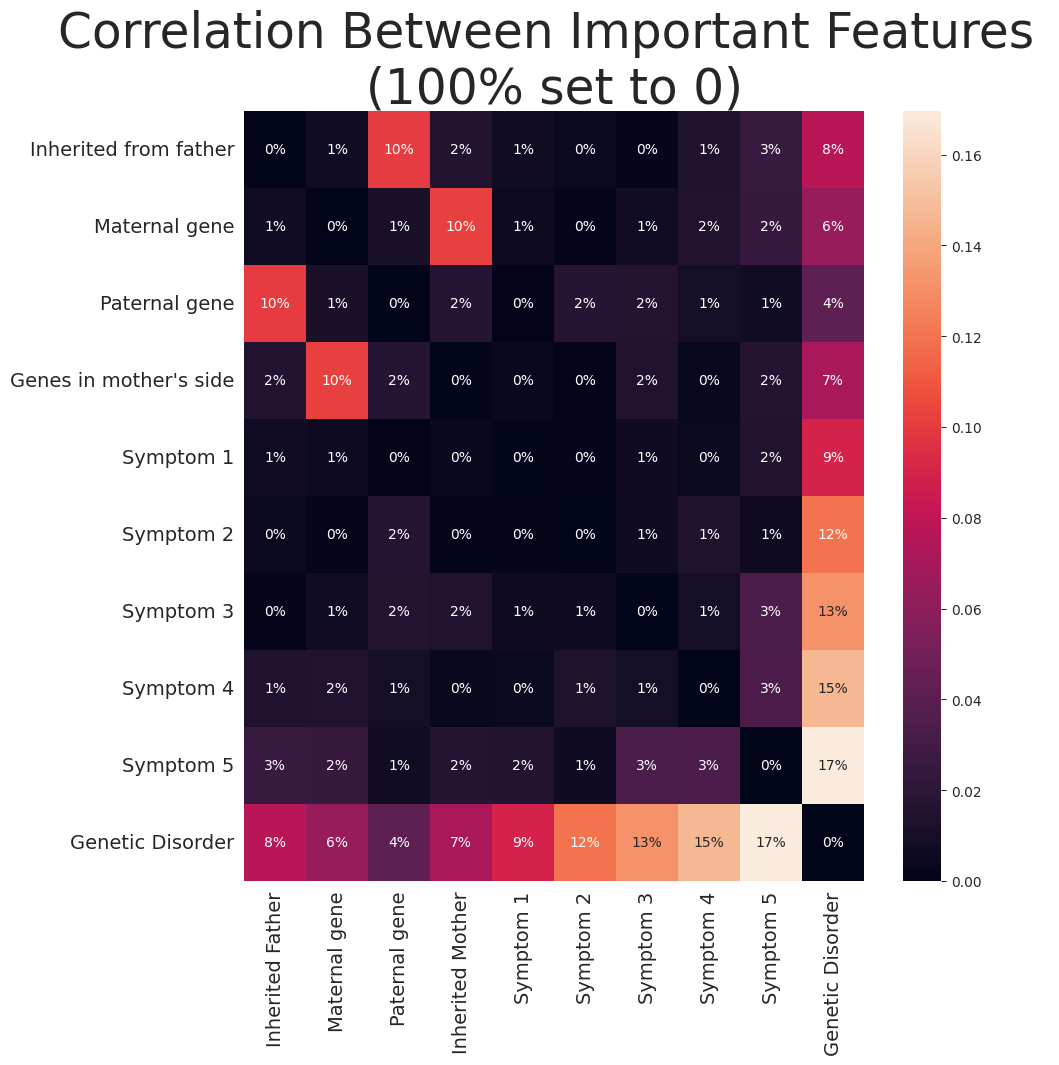

In [64]:
corr = heat_data.corr().applymap(lambda x: 0 if x > 0.99 else abs(x))
plt.figure(figsize=(10, 10))
sns.heatmap(corr.rename({'Inherited from father': 'Inherited Father', 'Genes in mother\'s side': 'Inherited Mother'}, axis=1), annot=True, fmt=".0%")
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
plt.title('Correlation Between Important Features \n(100% set to 0)', fontsize=35)
# plt.show()
plt.savefig('correlation.png', transparent=True, bbox_inches='tight')

In [4]:
robust_scaler = RobustScaler()

X_train, X_test, Y_train, Y_test = train_test_split(robust_scaler.fit_transform(heat_data.loc[:, features_used]),
                                                    heat_data.loc[:, 'Genetic Disorder'],
                                                    test_size=0.2, random_state=43)

In [5]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
lp_models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)
lp_models

100%|██████████| 29/29 [00:13<00:00,  2.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 9890, number of used features: 9
[LightGBM] [Info] Start training from score -2.249423
[LightGBM] [Info] Start training from score -0.668578
[LightGBM] [Info] Start training from score -0.962065


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.47,0.59,None,0.48,0.10
BaggingClassifier,0.65,0.59,None,0.65,0.05
LGBMClassifier,0.65,0.59,None,0.64,0.20
ExtraTreeClassifier,0.64,0.58,None,0.64,0.01
ExtraTreesClassifier,0.64,0.58,None,0.64,0.32
LabelPropagation,0.64,0.58,None,0.64,3.05
DecisionTreeClassifier,0.64,0.58,None,0.64,0.01
RandomForestClassifier,0.65,0.57,None,0.64,0.32
XGBClassifier,0.65,0.57,None,0.65,1.18


In [ ]:
lp_models

In [13]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [5,20,50,100, 200, 400 , 800] # number of trees in the random forest
max_features = ['sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 500, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2,4 ,6, 8, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4, 6] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}
## Importing Random Forest Classifier from the sklearn.ensemble

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

rf_random.fit(X_train, Y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 54, 99, 143, 188, 232,
                                                      277, 321, 366, 410, 455,
                                                      500],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 3, 4, 6],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [5, 20, 50, 100, 200,
                                                         400, 800]},
                   random_state=35, verbose=2)

In [14]:
print ('Random grid: ', random_grid, '\n')
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100, 200, 400, 800], 'max_features': ['sqrt'], 'max_depth': [10, 54, 99, 143, 188, 232, 277, 321, 366, 410, 455, 500], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 3, 4, 6], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 410, 'bootstrap': True}  


In [32]:
from sklearn.metrics import f1_score

model = RandomForestClassifier(bootstrap=True, max_depth=410, max_features='sqrt',
                       min_samples_leaf=6, min_samples_split=10, n_estimators=400)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)


In [33]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

f1_score(Y_test, y_pred, average='macro'), accuracy_score(Y_test, y_pred), precision_score(Y_test, y_pred, average='macro'), recall_score(Y_test, y_pred, average='macro')

(0.5782406983430132,
 0.6502224019409624,
 0.5966247156354406,
 0.5668867368839662)